In [39]:
import os
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [4]:
# path to the downloaded pairs of real and generated images
path = 'data'
n_pairs = 1000

In [47]:
# plot settings

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
linewidth = 3

In [3]:
# utility function to convert RGB into gray-scale images
def rgb2gray(images):
    return 0.299*images[:, :, :, 0] + 0.587*images[:, :, :, 1] + 0.114*images[:, :, :, 2]

# compute dissimilarity metric of truncated spectra
def fourier_dissimilarity(fake_images, real_images, metric, thres=1):
    fake_ft = torch.norm(torch.rfft(rgb2gray(fake_images), signal_ndim=2), dim=3)
    real_ft = torch.norm(torch.rfft(rgb2gray(real_images), signal_ndim=2), dim=3)
    if metric == '2':
        return torch.norm(fake_ft[:,thres:-thres,thres:]-real_ft[:,thres:-thres,thres:], p='fro', dim=(1, 2))
    elif metric == 'cos':
        vec_fake_ft = torch.flatten(fake_ft[:,thres:-thres,thres:], start_dim=1).unsqueeze(dim=1)
        vec_real_ft = torch.flatten(real_ft[:,thres:-thres,thres:], start_dim=1).unsqueeze(dim=2)
        return 1 - torch.bmm(vec_fake_ft, vec_real_ft).squeeze() / (torch.norm(vec_fake_ft, dim=2) * torch.norm(vec_real_ft, dim=1)).squeeze()
    else:
        return 0

In [5]:
# load images

real_list = []
fake_list = []

real_files = sorted(os.listdir(path+'real'))
fake_files = sorted(os.listdir(path+'fake'))

for idx in range(min(len(real_files), n_pairs)):
    real_list.append(plt.imread(path+'real/'+real_files[idx]))
    fake_list.append(plt.imread(path+'fake/'+fake_files[idx]))
    
real = torch.from_numpy(np.array(real_list))
fake = torch.from_numpy(np.array(fake_list)[:,:,:,:3])

In [7]:
# compute fourier dissimilarity for different frequency thresholds

fd_2_list = []
fd_cos_list = []

thresholds = np.arange(1, 128)

start = time.time()

for thres in thresholds:
    
    fd_2_list.append(fourier_dissimilarity(real, fake, '2', thres).numpy())
    fd_cos_list.append(fourier_dissimilarity(real, fake, 'cos', thres).numpy())
    
print(time.time()-start, 'seconds')
    
fd_2 = np.array(fd_2_list)
fd_cos = np.array(fd_cos_list)

/Users/max/opt/anaconda3/envs/env_DL/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:590.)
  import sys


2739.0960700511932 seconds


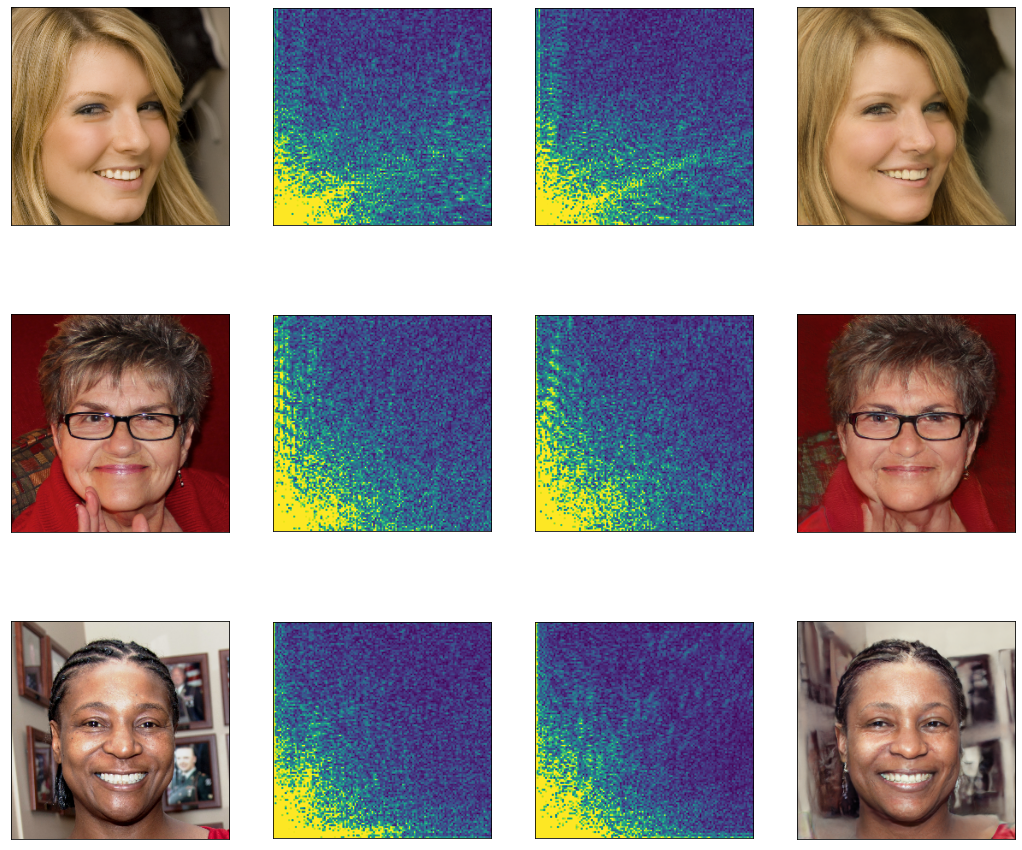

In [103]:
# visualize fourier representations

np.random.seed(9)
indices = np.random.choice(n_pairs, size=3)
real_sample = real[indices]
fake_sample = fake[indices]

real_sample_ft = torch.norm(torch.rfft(rgb2gray(real_sample), signal_ndim=2), dim=3)
fake_sample_ft = torch.norm(torch.rfft(rgb2gray(fake_sample), signal_ndim=2), dim=3)

f = plt.figure(figsize=(18,16))

for idx in range(3):
    
    ax_real = f.add_subplot(3,4,idx*4 + 1)
    ax_real_ft = f.add_subplot(3,4,idx*4 + 2)
    ax_fake_ft = f.add_subplot(3,4,idx*4 + 3)
    ax_fake = f.add_subplot(3,4,idx*4 + 4)
    
    ax_real.imshow(real_sample[idx])
    ax_real_ft.imshow(np.minimum(real_sample_ft[idx, 128:].numpy(), 2*np.mean(real_sample_ft[idx, 128:].numpy())))
    ax_fake_ft.imshow(np.minimum(fake_sample_ft[idx, 128:].numpy(), 2*np.mean(fake_sample_ft[idx, 128:].numpy())))
    ax_fake.imshow(fake_sample[idx])
    
    for ax in [ax_real, ax_real_ft, ax_fake_ft, ax_fake]:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])

Text(0, 0.5, 'cosine dissimilarity')

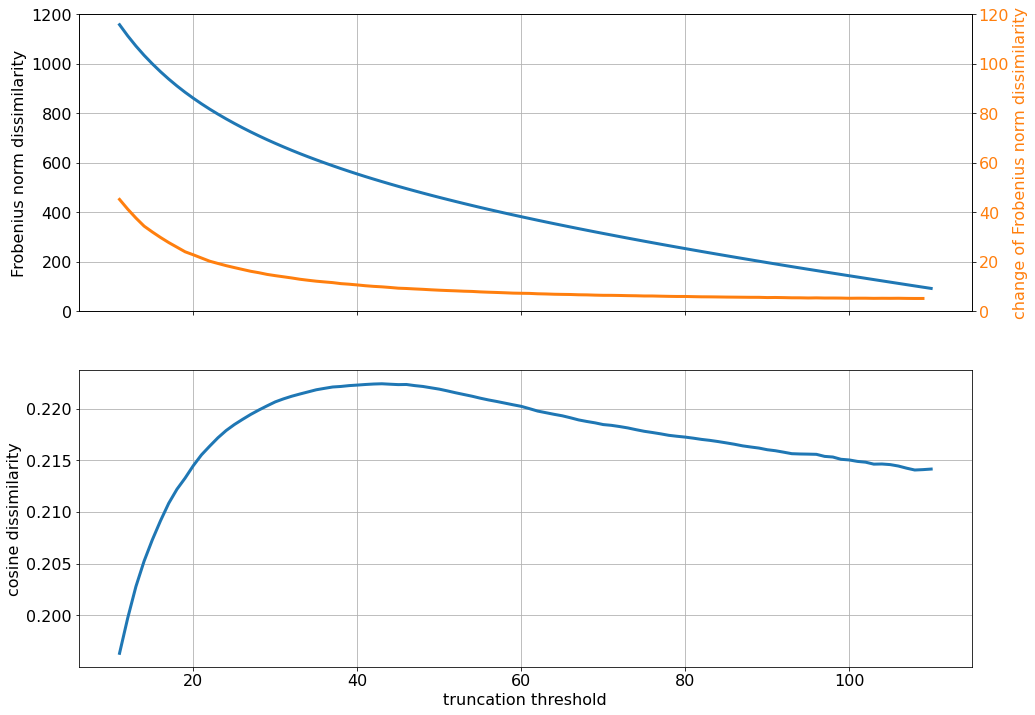

In [102]:
# plot fourier dissimilarity values

f = plt.figure(figsize=(16,12))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

plot_range = np.arange(10, 110)

ax1.plot(thresholds[plot_range], np.mean(fd_2[plot_range], axis=1), linewidth=linewidth)   #/np.sqrt((256-2*thresholds)*(128-thresholds)))#/((256-2*thresholds)*(128-thresholds))[:,None]) 
ax1.set_ylim([0, 1200])
ax1.set_xticklabels([])
color = 'tab:orange'
ax_diff = ax1.twinx() 
ax_diff.set_ylabel('change of Frobenius norm dissimilarity', color=color)
ax_diff.plot(thresholds[plot_range][:-1], -np.diff(np.mean(fd_2[plot_range], axis=1)), color=color, linewidth=linewidth)
ax_diff.tick_params(axis='y', labelcolor=color)
ax_diff.set_ylim([0, 120])
ax1.grid()
ax1.set_ylabel('Frobenius norm dissimilarity')

ax2.plot(thresholds[plot_range], np.mean(fd_cos[plot_range], axis=1), linewidth=linewidth)
ax2.grid()
ax2.set_xlabel('truncation threshold')
ax2.set_ylabel('cosine dissimilarity')